# COVID-19 in NSW
This project aims to analyse NSW Health's data about reported COVID-19 cases in NSW, to uncover any patterns or trends. In this project, I will clean, query, visualise and explain findings from the analysis.

Please see the [README](https://github.com/henrylin03/covid-nsw) for more information.


#### Data Source
[NSW COVID-19 cases by location](https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-aefcde60-3b0c-4bc0-9af1-6fe652944ec2/details?q=) is published by NSW Health.

## Setup


Create SQL engine and load input CSV into a SQLite table:


In [1]:
from glob import glob
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("sqlite://", echo=False)

covid_df = pd.read_csv(glob("./input/confirmed_cases*.csv")[0])
covid_df.to_sql("covid", engine, if_exists="replace", index=False)
covid_df.head(3)


,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),NaN,1
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),NaN,1
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),NaN,1


## Cleaning
The dataset is prepared for analysis by inspecting and cleaning, where appropriate.

### Removing suffix to LGAs
In the `lga_name19` column, some Local Government Areas (LGAs) have bracketed suffixes:
1. `(A)` and `(C)`: remove as do not appear to have significance in distinguishing LGAs. NSW Health did not provide guidance in the [dataset's dictionary](https://data.nsw.gov.au/data/dataset/covid-19-cases-by-location/resource/5d63b527-e2b8-4c42-ad6f-677f14433520) nor elsewhere.
2. `(NSW)`: remove as all LGAs are within NSW.

I will remove using SQL's `REPLACE()` function, and add to a new column "`lga`":

In [2]:
covid_lga_cleaned =\
    pd.read_sql_query(
        """
        SELECT *,
            REPLACE(
                REPLACE(
                    REPLACE(
                        lga_name19, ' (A)', ''
                    ), ' (C)', ''
                ), ' (NSW)', ''
            ) AS 'lga'
        FROM covid
    """,
        engine,
    )

covid_lga_cleaned.to_sql("covid", engine, if_exists="replace", index=False)
covid_lga_cleaned.head(3)

,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count,lga
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),None,1,Ku-ring-gai
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),None,1,Parramatta
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),None,1,Burwood


### Missing
There are missing values in both `postcode` and `confirmed_by_pcr` columns:

In [3]:
pd.read_sql_query(
    """
    SELECT SUM(CASE WHEN notification_date IS NULL THEN 1 ELSE 0 END) AS 'nd_miss',
        SUM(CASE WHEN postcode IS 'None' THEN 1 ELSE 0 END) AS 'pc_miss',
        SUM(CASE WHEN lhd_2010_code IS  NULL THEN 1 ELSE 0 END) AS 'lhdc_miss',
        SUM(CASE WHEN lhd_2010_name IS NULL THEN 1 ELSE 0 END) AS 'lhdn_miss',
        SUM(CASE WHEN lga_code19 IS NULL THEN 1 ELSE 0 END) AS 'lgac_miss',
        SUM(CASE WHEN lga_name19 IS NULL THEN 1 ELSE 0 END) AS 'lgan_miss',
        SUM(CASE WHEN confirmed_by_pcr IS NULL THEN 1 ELSE 0 END) AS 'pcr_miss',
        SUM(CASE WHEN confirmed_cases_count IS NULL THEN 1 ELSE 0 END) AS 'confirmed_cases_miss',
        SUM(CASE WHEN lga IS NULL THEN 1 ELSE 0 END) AS 'lga_miss'
    FROM covid
""",
    engine,
)


,nd_miss,pc_miss,lhdc_miss,lhdn_miss,lgac_miss,lgan_miss,pcr_miss,confirmed_cases_miss,lga_miss
0,0,573,0,0,0,0,41079,0,0


However, these are both difficult to impute:

* `postcode`: although Local Government Area (LGA) information is not missing for rows with missing `postcode`, LGA to postcode's relationship is M:M. There can be multiple postcodes in an LGA (eg [Georges River has 6 postcodes](https://www.worldpostalcodes.org/l1/en/au/australia/map/r2/map-of-postcodes-in-georges-river)), and a postcode can be in multiple LGAs (eg [2153 (Baulkham Hills) is in both The Hills and Parramatta LGAs](https://en.wikipedia.org/wiki/Baulkham_Hills,_New_South_Wales).


* `confirmed_by_pcr` records whether a case detected by Rapid Antigen Tests (RAT) was also confirmed by PCR. All missing values were prior to 19 Jan 2022 (_see below_) and would be difficult to impute.

In [4]:
pd.read_sql_query(
    """
        SELECT MAX(notification_date) AS 'latest_pcr_miss_date'
        FROM covid
        WHERE confirmed_by_pcr IS NULL
    """,
    engine,
)


,latest_pcr_miss_date
0,2022-01-19


## Analysis

In this section, I use SQL queries and Python visualisations to highlight insights in the data.


### Daily cases have trended upwards
Since reporting started on 25 Jan 2020, daily cases have trended upwards, **peaking in Jan 2022**, and then to a lesser peak in Mar 2022.

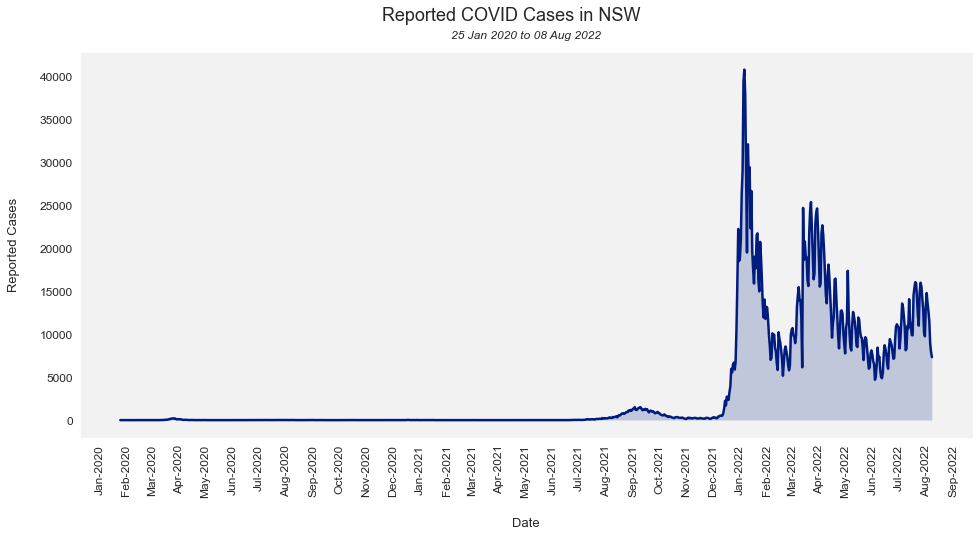

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# querying
daily_cases = pd.read_sql_query(
    """
        SELECT DATE(notification_date) AS 'date',
            SUM(confirmed_cases_count) AS 'reported_cases'
        FROM covid
        GROUP BY 1
    """,
    engine,
)

# transforming and extracting from DataFrame for visualisation
daily_cases["date"] = pd.to_datetime(daily_cases["date"], format="%Y-%m-%d")
start_date = daily_cases.date.min().strftime("%d %b %Y")
end_date = daily_cases.date.max().strftime("%d %b %Y")

# plotting visualisation
sns.set_style("dark", {"axes.facecolor": "0.95"})
sns.set_palette("dark")

fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x="date", y="reported_cases", data=daily_cases, ax=ax, linewidth=2.5)
plt.fill_between(x=daily_cases["date"], y1=daily_cases["reported_cases"], alpha=0.2)

# setting x-axis ticks
ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(md.DateFormatter("%b-%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.tick_params(axis="both", labelsize=12)

# modifying line-chart parameters
ax.figure.suptitle("Reported COVID Cases in NSW", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.set_xlabel("Date", fontsize=13, labelpad=20)
ax.set_ylabel("Reported Cases", fontsize=13, labelpad=20)

fig.subplots_adjust(top=0.89)

plt.show()
plt.clf()


#### Cases peaked in Jan 2022, and then in Mar 2022...
The **top 10 daily cases all occurred in _Jan 2022_**. 11th to 16th are part of the Mar 2022 spike. 

In [6]:
pd.read_sql_query(
    """
    SELECT
        RANK() OVER (
            ORDER BY SUM(confirmed_cases_count) DESC
        ) AS 'rank',
        DATE(notification_date) AS 'date',
        STRFTIME('%m-%Y', notification_date) AS 'month_year',
        SUM(confirmed_cases_count) AS 'reported_cases'
    FROM covid
    GROUP BY 2
    ORDER BY 4 DESC
    LIMIT 20
""",
    engine,
)


,rank,date,month_year,reported_cases
0,1,2022-01-06,01-2022,40752
1,2,2022-01-05,01-2022,39431
2,3,2022-01-07,01-2022,37676
3,4,2022-01-10,01-2022,32070
4,5,2022-01-12,01-2022,29411
5,6,2022-01-04,01-2022,29031
6,7,2022-01-08,01-2022,28174
7,8,2022-01-11,01-2022,28137
8,9,2022-01-14,01-2022,26646
9,10,2022-01-03,01-2022,26374


#### Cases typically peak mid-week, decreasing into the weekend, then rebounding on Mondays... 
Over the reporting period, average daily cases tend to increase after the weekend, **peaking on Wednesdays** (daily average = 14.9 cases), before **reducing into the weekend until Sundays** (daily average = 11 cases).

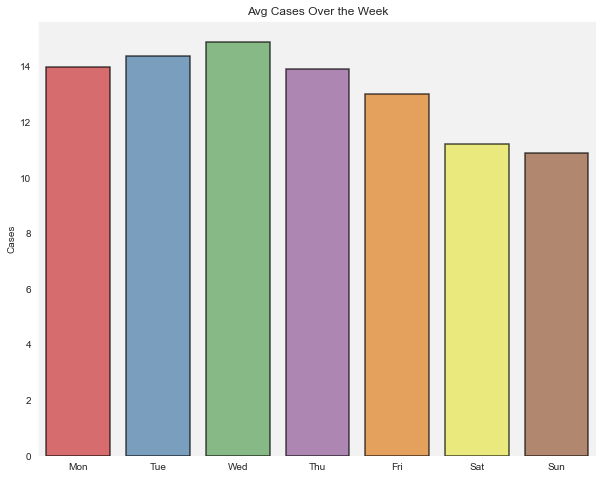

,day_of_wk,cases_avg
1,Mon,14.0
2,Tue,14.4
3,Wed,14.9
4,Thu,13.9
5,Fri,13.0
6,Sat,11.2
0,Sun,10.9


<Figure size 432x288 with 0 Axes>

In [7]:
days_of_wk = pd.read_sql_query(
    """
    SELECT
        SUBSTR(
            'SunMonTueWedThuFriSat',
            1 + 3 * STRFTIME('%w', notification_date), 3
        ) AS 'day_of_wk',
        ROUND(
            AVG(confirmed_cases_count), 1
        ) AS 'cases_avg'
    FROM covid
    GROUP BY 1
    ORDER BY STRFTIME('%w', notification_date)
""",
    engine,
)

# Ordering by STRFTIME('%w') would start the week on Sunday instead of Monday
days_of_wk["day_of_wk"] = pd.Categorical(
    days_of_wk.day_of_wk,
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    ordered=True,
)
days_of_wk.sort_values("day_of_wk", inplace=True)

# Plotting
sns.set_palette("Set1", 7)

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=days_of_wk,
    x="day_of_wk",
    y="cases_avg",
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
    alpha=0.7,
).set(xlabel=None, ylabel="Cases", title="Avg Cases Over the Week")

plt.show()
plt.clf()

display(days_of_wk)


### "Zero" days
Days without any COVID-19 cases were more frequent at the beginning of the reporting period. **Feb 2020 was an entire *month* of zero days.**

In [17]:
zero_days_df = pd.read_sql_query(
    """
        WITH RECURSIVE dates(date) AS (
            VALUES((
                SELECT MIN(notification_date)
                FROM covid
                )
            )
            UNION ALL
            SELECT DATE(date, '+1 day')
            FROM dates
            WHERE date < (
                SELECT MAX(notification_date)
                FROM covid
                )
            )

        SELECT
            d.*
        FROM dates d
        LEFT JOIN covid c
            ON c.notification_date = d.date
        WHERE c.notification_date IS NULL
        ORDER BY 1
        """,
    engine,
)

zero_days_df.to_sql("zero_days", engine, if_exists="replace", index=False)
zero_days_df

,date
0,2020-01-26
1,2020-01-28
2,2020-01-29
3,2020-01-30
4,2020-01-31
...,...
86,2021-05-31
87,2021-06-01
88,2021-06-03
89,2021-06-11


In [9]:
pd.read_sql_query(
    """
    SELECT 
        STRFTIME('%Y-%m', date) AS 'year_month',
        COUNT(*) AS 'zero_days_count'
    FROM zero_days
    GROUP BY 1
    ORDER BY 1
""",
    engine,
)


,year_month,zero_days_count
0,2020-01,5
1,2020-02,29
2,2020-05,9
3,2020-06,4
4,2020-09,3
5,2020-10,1
6,2020-11,3
7,2021-01,7
8,2021-02,10
9,2021-03,6


#### Days since the last "zero" day
As of the latest date in the dataset, the days since the last "zero day" is...

In [10]:
from IPython.display import Markdown
import numpy as np

last_zeroday = pd.to_datetime(zero_days_df.date.max())
days_since_zero = round(
    (daily_cases.date.max() - last_zeroday) / np.timedelta64(1, "D")
)

display(
    Markdown(
        f"""
<h1 align='center'>{days_since_zero}</h1>
<div align='center'><br>days since the last COVID-zero day</div>"""
    )
)



<h1 align='center'>422</h1>
<div align='center'><br>days since the last COVID-zero day</div>

#### The longest streak of "zero" days was 33 days
Since reporting began 25 Jan 2020, the longest streak began on 28 Jan 2020, and lasted until 1 Mar 2020. 

Conscious testing rates were likely low as [Australia only reported its first COVID case on 25 Jan 2020](https://www.health.gov.au/ministers/the-hon-greg-hunt-mp/media/first-confirmed-case-of-novel-coronavirus-in-australia), the second longest streak of 4 days began on 11 Feb 2021, and lasted until 15 Feb 2021:

In [11]:
# I minus 1 day from the difference between two dates where there were 1+ reported cases,
# as the calculation includes the day that breaks the streak (and has 1+ reported cases)

zd_streaks = pd.read_sql_query(
    """
        WITH daily_cases AS (
            SELECT 
                DATE(notification_date) AS 'date',
                SUM(confirmed_cases_count) AS 'reported_cases'
            FROM covid
            GROUP BY 1
        )

        SELECT *
        FROM (
            SELECT 
                date AS 'date_streak_broken', 
                ROUND(
                    JULIANDAY(date) 
                    - JULIANDAY(
                            LAG(date) OVER (
                                ORDER BY date
                            )
                    )
                - 1) AS 'date_diff'
            FROM daily_cases
        )
        WHERE date_diff > 0
        ORDER BY date_diff DESC
    """,
    engine,
)

# `date_diff` = 0 is filtered out as these mean no zero days in between those dates

zd_streaks["date_diff"] = zd_streaks["date_diff"].astype(int)

zd_streaks.head()


,date_streak_broken,date_diff
0,2020-03-01,33
1,2021-02-15,4
2,2020-05-18,3
3,2021-06-02,3
4,2020-05-12,2


#### Most "zero" days were not consecutive
Examining the right-skewed distribution of "zero" day streaks, **72% of "zero" days were non-consecutive.** The 33-day streak, at the beginning of 2020, is an _outlier_ within the dataset.

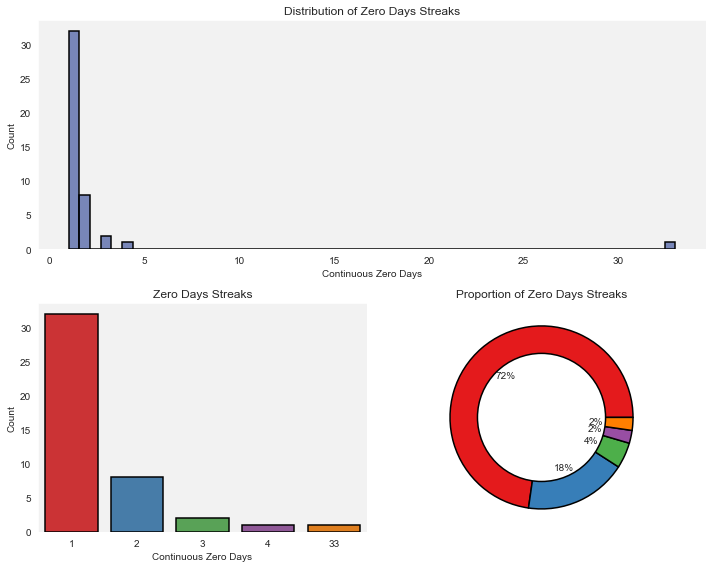

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 2)
f = plt.figure(figsize=(10, 8))

# histogram for distribution
sns.set_palette("dark")
zd_hist = f.add_subplot(gs[:-1, :])
sns.histplot(
    data=zd_streaks,
    x="date_diff",
    alpha=0.5,
    legend=False,
    edgecolor="black",
    linewidth=1.5,
).set(xlabel="Continuous Zero Days", title="Distribution of Zero Days Streaks")

# countplot for distribution
sns.set_palette("Set1")
zd_countp = f.add_subplot(gs[1, 0])
sns.countplot(data=zd_streaks, x="date_diff", edgecolor="black", linewidth=1.5).set(
    xlabel="Continuous Zero Days", ylabel="Count", title="Zero Days Streaks"
)

# donut chart for proportion
zd_prop = f.add_subplot(gs[1, 1])
## transforming table for donut chart generation
zd_streaks_count = (
    zd_streaks.groupby("date_diff")
    .count()
    .reset_index()
    .rename(columns={"date_streak_broken": "date_diff_count"})
)
zd_donut = plt.pie(
    zd_streaks_count["date_diff_count"],
    wedgeprops={"linewidth": 1.5, "edgecolor": "black"},
    autopct="%d%%",
)
plt.title("Proportion of Zero Days Streaks")

my_circle = plt.Circle((0, 0), 0.7, facecolor="white", edgecolor="black", linewidth=1.5)
p = plt.gcf()
p.gca().add_artist(my_circle)


gs.tight_layout(f)
plt.show()
plt.clf()


#### "Zero" days occur slightly more on Saturdays...
"Zero" days are approximately the same over the week. 18% of "zero" days occurred on Saturdays (16 times).

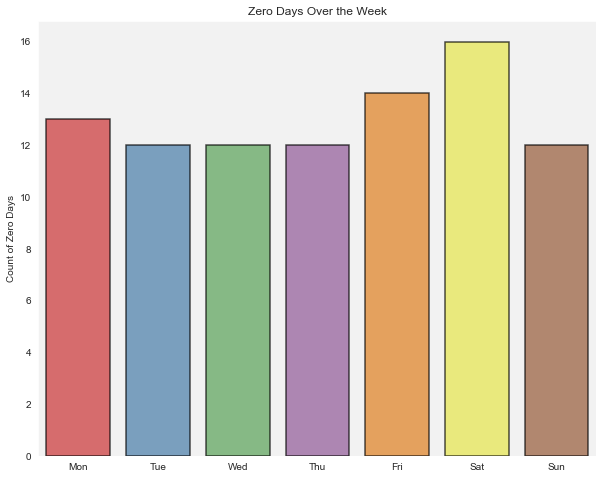

,day_of_wk,zero_days_count,proportion
0,Mon,13,0.14
1,Tue,12,0.13
2,Wed,12,0.13
3,Thu,12,0.13
4,Fri,14,0.15
5,Sat,16,0.18
6,Sun,12,0.13


<Figure size 432x288 with 0 Axes>

In [13]:
zd_days_of_wk = pd.read_sql_query(
    """
    SELECT
        SUBSTR(
            'SunMonTueWedThuFriSat',
            1 + 3 * STRFTIME('%w', date), 3
        ) AS 'day_of_wk',
        COUNT(*) AS 'zero_days_count',
        ROUND(
            1.0 * COUNT(*) / (
                SELECT COUNT(*)
                FROM zero_days
            ), 2) AS proportion
    FROM zero_days
    GROUP BY 1
    ORDER BY STRFTIME('%w', date)
""",
    engine,
)

zd_days_of_wk["day_of_wk"] = pd.Categorical(
    days_of_wk.day_of_wk,
    ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    ordered=True,
)
zd_days_of_wk.sort_values("day_of_wk", inplace=True)

# Plotting
sns.set_palette("Set1", 7)
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=zd_days_of_wk,
    x="day_of_wk",
    y="zero_days_count",
    edgecolor="black",
    linewidth=1.5,
    ax=ax,
    alpha=0.7,
).set(xlabel=None, ylabel="Count of Zero Days", title="Zero Days Over the Week")

plt.show()
plt.clf()

display(zd_days_of_wk)


### Location

#### _Blacktown_ LGA has had the highest number of reported cases in NSW
...with 160,000+ cases to date. _Unincorporated NSW_ LGA has the lowest count with < 100 cases since reporting started ("Hotel Quarantine" is not a true "LGA").

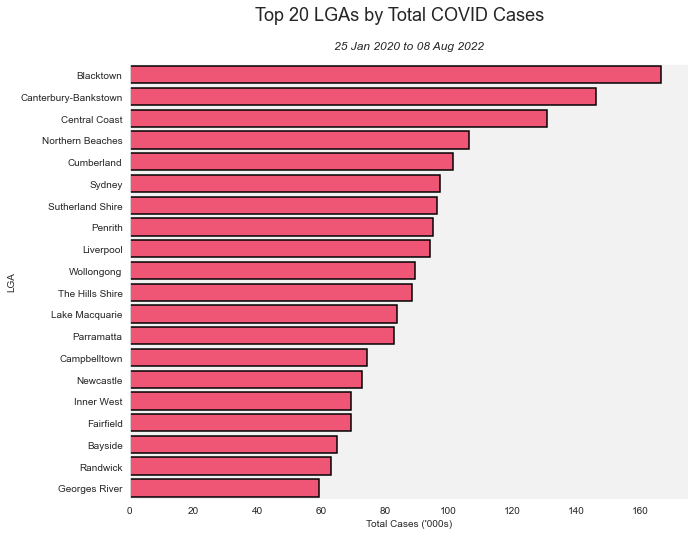

LGAs by total COVID cases from 25 Jan 2020 to 08 Aug 2022:


,lga,total_cases,avg_daily_cases
0,Blacktown,166528,179
1,Canterbury-Bankstown,146216,157
2,Central Coast,130673,141
3,Northern Beaches,106312,114
4,Cumberland,101293,109
...,...,...,...
126,Central Darling,600,0
127,Carrathool,433,0
128,Brewarrina,408,0
129,Unincorporated NSW,82,0


<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.ticker as ticker

lga_cases_total =\
    pd.read_sql_query(
    """
        SELECT lga, 
            SUM(confirmed_cases_count) AS 'total_cases',
            CAST(
                1.0 * SUM(confirmed_cases_count) / (
                    SELECT JULIANDAY(MAX(notification_date)) -
                        JULIANDAY(MIN(notification_date))
                    FROM covid
                )
            AS INT) AS 'avg_daily_cases'
        FROM covid
        GROUP BY 1
        ORDER BY 2 DESC
    """, engine)

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x="total_cases", y="lga", data=lga_cases_total.head(20), 
             orient="h", 
             saturation=8, color="#ef5675",
             edgecolor="black", linewidth=1.5, 
            ax=ax)\
        .set(xlabel="Total Cases ('000s)", 
             ylabel="LGA")
ax.figure.suptitle("Top 20 LGAs by Total COVID Cases", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000)))


plt.show()
plt.clf()
print(f"LGAs by total COVID cases from {start_date} to {end_date}:")
lga_cases_total

#### Most LGAs have < 10,000 total cases...
As seen in histogram below, the majority of LGAs have had less than 10,000 total cases to date. 

The top 4 LGAs have 100,000+ reported cases each, but these are outliers across NSW.

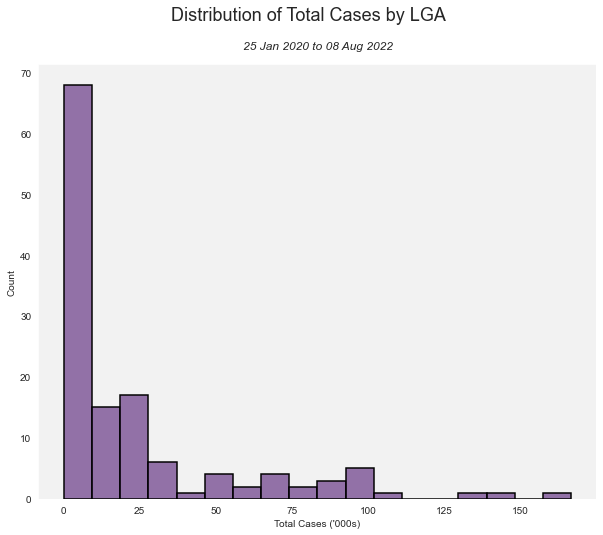

<Figure size 432x288 with 0 Axes>

In [15]:
fig, ax = plt.subplots(figsize=(10,8))

sns.histplot(data=lga_cases_total, x="total_cases", 
             color="#7a5195", alpha=0.8,
             edgecolor="black", 
             linewidth=1.5, 
             ax=ax)\
    .set(xlabel="Total Cases ('000s)")

ax.figure.suptitle("Distribution of Total Cases by LGA", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000)))

plt.show()
plt.clf()

Looking by map...

#### The first case was detected in //LGA

#### The last LGA to get their first case was //LGA

In [16]:
# windows function to get the first covid case in each LGA, and then find the one that is the latest in time

pd.read_sql_query(
"""
    SELECT *
    FROM covid
    LIMIT 5
""", engine)

,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count,lga
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),None,1,Ku-ring-gai
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),None,1,Parramatta
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),None,1,Burwood
3,2020-01-27,2033,X720,South Eastern Sydney,16550,Randwick (C),None,1,Randwick
4,2020-03-01,2077,X760,Northern Sydney,14000,Hornsby (A),None,1,Hornsby


#### The highest case count in postcode is //LGA

## Conclusion
In this project, I have analysed and highlighted insights in NSW Health's COVID-19 dataset. 